In [1]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from skopt import BayesSearchCV
import skopt.space as space
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.pipeline import Pipeline


In [2]:
from ff_custom_scripts import *

train, test,leaderboard,holdout = load_files(nanvalues='remove')

print(train.shape, test.shape,leaderboard.shape,holdout.shape)

(1172, 1210) (294, 1210) (530, 1210) (1111, 1210)


# Model

In [3]:
def run_model(train, target='gpa', classifier=False):

    X_train, y_train = prepare_data(train, target)
    print(X_train.shape, y_train.shape)
    
    print(X_train.shape, y_train.shape)

    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    numerical_features = cols_per_type(X_train, 'Continuous')
    print(f'N. of numerical features: {len(numerical_features)}')
    categorical_features = cols_per_type(X_train, 'Ordered Categorical')
    print(f'N. of categorical features: {len(categorical_features)}')
    binary_features = cols_per_type(X_train, 'Binary')
    print(f'N. of binary features: {len(binary_features)}')
    ordinal_features = cols_per_type(X_train, 'Unordered Categorical')
    print(f'N. of ordinal features: {len(ordinal_features)}')

    preprocessor = make_column_transformer(
        (categorical_transformer, categorical_features),
        ('passthrough', numerical_features),
        ('passthrough', ordinal_features),
        ('passthrough', binary_features)
    )

    search_space = {
        'regressor__learning_rate': space.Real(0.01, 0.06),
        'regressor__max_depth': space.Integer(5, 15),
    }

    if classifier:
        score = 'neg_brier_score'
        lgbm = LGBMClassifier(learning_rate=0.01, max_depth=8,random_state=123)
        search_space.update({'regressor__scale_pos_weight': space.Integer(25, 35)})
    else:
        lgbm = LGBMRegressor(random_state=123)
        score = 'neg_mean_squared_error'

    pipes = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', lgbm)])
    
    model = BayesSearchCV(
        pipes,
        search_space,
        n_iter=10,
        cv=5,
        n_jobs=-1,
        scoring=score,
        refit=True,
        verbose=0,
        random_state=41
    )
 
    # ytrain shape
    model.fit(X_train, y_train)

    return model


# GPA

In [4]:
gpa_model = run_model(train,target='gpa', classifier=False)

(929, 1204) (929,)
(929, 1204) (929,)
N. of numerical features: 106
N. of categorical features: 414
N. of binary features: 570
N. of ordinal features: 114


In [5]:
score_model(gpa_model,'gpa',test,leaderboard,holdout=None,classifier=False)

Metric: mean_squared_error
Best CV score: 0.4022
Standard deviation of CV scores: 0.0352
Mean CV score: 0.4088
Test MSE: 0.4083
Test R2: 0.0971
>> Leaderboard MSE: 0.3938
Leaderboard R2: -0.0082


# Material Hardship

In [6]:
model_materialHardship = run_model(train,target='materialHardship', classifier=False)

(1167, 1204) (1167,)
(1167, 1204) (1167,)
N. of numerical features: 106
N. of categorical features: 414
N. of binary features: 570
N. of ordinal features: 114


In [7]:
model_materialHardship.best_params_

OrderedDict([('regressor__learning_rate', 0.022288208566756673),
             ('regressor__max_depth', 9)])

In [8]:
score_model(model_materialHardship, target='materialHardship', test=test, leaderboard=leaderboard, holdout=None, classifier=False)

Metric: mean_squared_error
Best CV score: 0.0216
Standard deviation of CV scores: 0.0036
Mean CV score: 0.0218
Test MSE: 0.0206
Test R2: 0.1833
>> Leaderboard MSE: 0.0249
Leaderboard R2: 0.1301


# Grit


In [9]:
model_grit = run_model(train,target='grit', classifier=False)

(1134, 1204) (1134,)
(1134, 1204) (1134,)
N. of numerical features: 106
N. of categorical features: 414
N. of binary features: 570
N. of ordinal features: 114


In [10]:
model_grit.best_params_

OrderedDict([('regressor__learning_rate', 0.012104671856054891),
             ('regressor__max_depth', 15)])

In [11]:
score_model(model_grit, target='grit', test=test, leaderboard=leaderboard, holdout=None, classifier=False)

Metric: mean_squared_error
Best CV score: 0.2396
Standard deviation of CV scores: 0.0407
Mean CV score: 0.2483
Test MSE: 0.2202
Test R2: 0.0182
>> Leaderboard MSE: 0.2254
Leaderboard R2: -0.0258


# Eviction

In [12]:
model_eviction = run_model(train,target='eviction', classifier=True)

(1167, 1204) (1167,)
(1167, 1204) (1167,)
N. of numerical features: 106
N. of categorical features: 414
N. of binary features: 570
N. of ordinal features: 114


In [13]:
score_model(model_eviction, target='eviction', test=test, leaderboard=leaderboard, holdout=None, classifier=True)

Scores without threshold adjusment
Test Brier: 0.0514
Test F1: 0.0000
Leaderboard Brier: 0.0566
Number of positive predictions: 0.0
>> Leaderboard F1: 0.0000
Leaderboard Accuracy: 0.9434
Leaderboard Recall: 0.0000


Scores with threshold adjusment


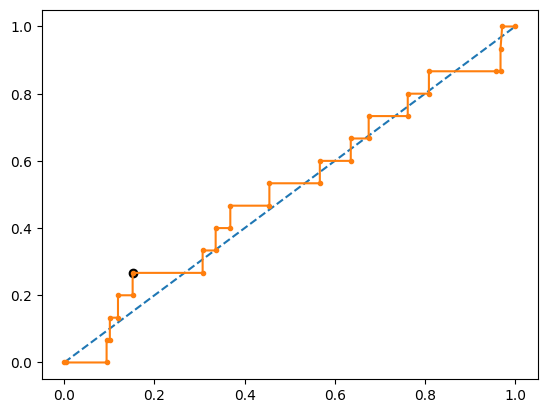

Threshold=0.113, FPR=0.152, TPR=0.267
Test brier: 0.185
Test F1: 0.100
Leaderboard Brier: 0.162
              precision    recall  f1-score   support

         0.0       0.95      0.88      0.91       500
         1.0       0.09      0.20      0.12        30

    accuracy                           0.84       530
   macro avg       0.52      0.54      0.52       530
weighted avg       0.90      0.84      0.87       530

Leaderboard F1: 0.122


In [14]:
score_classifier(model_eviction, target='eviction', test=test, leaderboard=leaderboard, holdout=None)

# jobTraining

In [15]:
model_job = run_model(train,target='jobTraining', classifier=True)

(1169, 1204) (1169,)
(1169, 1204) (1169,)
N. of numerical features: 106
N. of categorical features: 414
N. of binary features: 570
N. of ordinal features: 114


In [16]:
score_model(model_job, target='jobTraining', test=test, leaderboard=leaderboard, holdout=None, classifier=True)

Scores without threshold adjusment
Test Brier: 0.3493
Test F1: 0.4270
Leaderboard Brier: 0.3906
Number of positive predictions: 166.0
>> Leaderboard F1: 0.3387
Leaderboard Accuracy: 0.6094
Leaderboard Recall: 0.3605


Scores with threshold adjusment


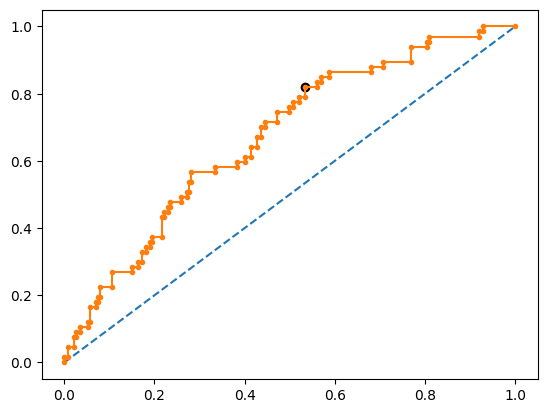

Threshold=0.404, FPR=0.533, TPR=0.821
Test brier: 0.455
Test F1: 0.448
Leaderboard Brier: 0.498
              precision    recall  f1-score   support

         0.0       0.74      0.49      0.58       383
         1.0       0.29      0.54      0.38       147

    accuracy                           0.50       530
   macro avg       0.51      0.51      0.48       530
weighted avg       0.61      0.50      0.53       530

Leaderboard F1: 0.377


In [17]:
score_classifier(model_job, target='jobTraining', test=test, leaderboard=leaderboard, holdout=None)

# Layoff

In [18]:
model_layoff = run_model(train, target='layoff', classifier=True)

(1026, 1204) (1026,)
(1026, 1204) (1026,)
N. of numerical features: 106
N. of categorical features: 414
N. of binary features: 570
N. of ordinal features: 114


In [19]:
model_layoff.best_params_

OrderedDict([('regressor__learning_rate', 0.012104671856054891),
             ('regressor__max_depth', 15),
             ('regressor__scale_pos_weight', 32)])

Scores with threshold adjusment


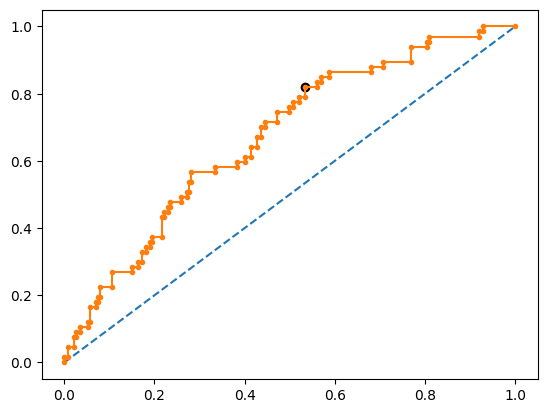

Threshold=0.404, FPR=0.533, TPR=0.821
Test brier: 0.455
Test F1: 0.448
Leaderboard Brier: 0.498
              precision    recall  f1-score   support

         0.0       0.74      0.49      0.58       383
         1.0       0.29      0.54      0.38       147

    accuracy                           0.50       530
   macro avg       0.51      0.51      0.48       530
weighted avg       0.61      0.50      0.53       530

Leaderboard F1: 0.377


In [20]:
score_classifier(model_job, target='jobTraining', test=test, leaderboard=leaderboard, holdout=None)